<h1>optAPM</h1>

Optimized Absolute Plate Motion models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nlopt
import ipyparallel
import time

from optapm import ModelSetup as ms, ProcessResults as pr
from functools import partial
from IPython.display import display, HTML
from datetime import datetime, timedelta

%matplotlib inline

<h3>Set model parameters, load data, and calculate starting conditions</h3>

Sets all user-selected parameters for the mode run

<b>Arguments:</b>

* geographical_uncertainty : Number that approximately represents geographical uncertainty - 95% confidence limit around 
  ref pole location 
* rotation_uncertainty : Number that represents the upper and lower bounds of the optimisation's angle variation
* sample_space : Selects the sampling method to be used to generate start seeds. "Fisher" (spherical distribution) by default.
* models : The total number of models to be produced. 1 model = 1 complete optimisation from 1 starting location
* model_stop_condition : Type of condition to be used to terminate optimisation. "threshold" or "max_iter". Threshold by default.
* max_iter : IF "max_iter" selected, sets maximum iterations regardless of successful convergence.
* ref_rotation_plate_id : Plate to be used as fixed reference. 701 (Africa) by default.
* ref_rotation_start_age : Rotation begin age.
* ref_rotation_end_age : Rotation end age.
* interpolation_resolution : Resolution in degrees used in the Fracture Zone calulcations
* rotation_age_of_interest : The result we are interested in. Allows for 'windowed mean' approach. It is the midpoint between the start and end ages by default.
			
<b>Data to be included in optimisation: True by default.</b>

* fracture_zones : Boolean
* net_rotation : Boolean
* trench_migration : Boolean
* hotspot_reconstruction : Boolean
* hotspot_dispersion : Boolean

optAPM002

Start age: 90.0 Ma

Search type: Initial
Search radius: 60

- Data loaded
 
Optimisation parameters:
 
Data constraints:
- Fracture zone orientation
- Net rotation
- Trench migration
- Hotspot trails
 
Termination:
- Threshold
 
Sampling method:
- Uniform
 
Reference rotation type:
- Auto-calc palaeomagnetic
 
Reference finite rotation pole for Africa at 90.0 Ma:
- Lon: -43.9
- Lat: -0.0
- Angle: -25.7569060773
 
- Created optimisation input vector
- Upper and lower bounds calculated
- Precomputed isopolate output
- Generated hotspot and trail data sets
 
 
Start seeds generated: 80


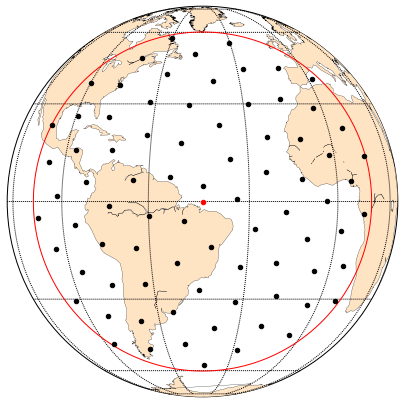

In [42]:
model_name = "optAPM002"
print model_name
print ""

search = "Initial"
#search = "Secondary"

# Large area grid search to find minima
if search == 'Initial':

    search_type = 'Uniform'
    search_radius = 60
    rotation_uncertainty = 30
    
    models = 80
    auto_calc_ref_pole = True
    
# Uses grid search minima as seed for targeted secondary search (optional)
elif search == 'Secondary':

    search_type = 'Uniform'
    search_radius = 15
    rotation_uncertainty = 30
    
    models = 60
    auto_calc_ref_pole = False
    
    
ref_rot_longitude = -53.5
ref_rot_latitude = 56.6
ref_rot_angle = -2.28


model_stop_condition = 'threshold'
max_iter = 20

ref_rotation_plate_id = 701
ref_rotation_start_age = 90.
ref_rotation_end_age = ref_rotation_start_age - 10
#ref_rotation_end_age = 0.

interpolation_resolution = 5
rotation_age_of_interest = True


# Choose data constraints to be used (Boolean)
# Spreading directions only appear useful back to 40Ma
# if ref_rotation_start_age <= 70:
    
#     fracture_zones = True
    
# else:
    
#     fracture_zones = False

fracture_zones = True
net_rotation = True
trench_migration = True
hotspot_trails = True

print "Start age:", ref_rotation_start_age, "Ma"
print ""
print "Search type:", search
print "Search radius:", search_radius
print ""

# --------------------------------------------------------------------

# Gather parameters
params = [search_radius, rotation_uncertainty, search_type, models, model_stop_condition, max_iter,
          ref_rotation_plate_id, ref_rotation_start_age, ref_rotation_end_age, interpolation_resolution, 
          rotation_age_of_interest, fracture_zones, net_rotation, trench_migration, hotspot_trails,
          ref_rot_longitude, ref_rot_latitude, ref_rot_angle, auto_calc_ref_pole, search]

# --------------------------------------------------------------------

## Data

#datadir = '/Users/Mike/Projects/optAPM/data/'
datadir = '/Users/MikeT/IPython/scripting/optAPM/data/'
#rotfile = 'Global_EarthByte_230-0Ma_GK07_AREPS.rot'
rotfile = 'Global_EarthByte_230-0Ma_GK07_AREPS_optAPM002.rot'
pmag_rotfile = 'Palaeomagnetic_Africa_S.rot'
nnr_datadir = 'TMData/'
nnr_rotfile = 'Global_EarthByte_230-0Ma_GK07_AREPS_NNR.rot'
ridge_file = 'Global_EarthByte_230-0Ma_GK07_AREPS_Ridges.gpml'
isochron_file = 'Global_EarthByte_230-0Ma_GK07_AREPS_Isochrons.gpmlz'
isocob_file = 'Global_EarthByte_230-0Ma_GK07_AREPS_IsoCOB.gpml'
hst_file = 'HotspotTrails.geojson'
hs_file = 'HotspotCatalogue2.geojson'


# Load all data
data = ms.dataLoader(datadir, rotfile, pmag_rotfile, nnr_rotfile=nnr_rotfile, nnr_datadir=nnr_datadir, 
                     ridge_file=ridge_file, isochron_file=isochron_file, isocob_file=isocob_file, hst_file=hst_file, 
                     hs_file=hs_file)

# --------------------------------------------------------------------

# Calculate starting conditions
startingConditions = ms.modelStartConditions(params, data)


### Objective function

Comprised of a set of individual functions each designed to assess the success of an iteration in finding a 'best-fit' solution to each specific data types included in the optimisation. 

In [43]:
def obj_f(x, grad):
    
    import numpy as np
    import pygplates as pgp
    import optimisation_methods
    import obj_func_convergence
    import geoTools
    import pmag
    
    from optapm import ObjectiveFunctions
    
    
    # Prepare rotation model for updates during optimisation - keeps rotations in memory
    file_registry = pgp.FeatureCollectionFileFormatRegistry()
    rotation_model_tmp = file_registry.read(rotation_file)
    
   

    #### -----------------------------------------------------------------------------------------
    #### 1. Calculate reconstructed data point locations

    tmp_opt_rlon = []
    tmp_opt_rlat = []
    opt_stats = []

    # Check incoming Africa finite rotation pole values
    if x[1] > 90:
    
        lon_ = x[0]
        lat_ = 90
        ang_ = x[2]
        
    elif x[1] < -90:
        
        lon_ = x[0]
        lat_ = -90
        ang_ = x[2]
    
    else:
        
        lon_ = x[0]
        lat_ = x[1]
        ang_ = x[2]
        
        
    if lon_ > 360:
        
        lon_ = lon_ - 360
        
       
         
    #### -----------------------------------------------------------------------------------------
    #### 2. Find and update Africa rotation
    
    
    # Find existing rotation for Africa at correct time
    opt_rotation_feature = None
    for rotation_feature in rotation_model_tmp:

        total_reconstruction_pole = rotation_feature.get_total_reconstruction_pole()

        if total_reconstruction_pole:
            
            fixed_plate_id, moving_plate_id, rotation_sequence = total_reconstruction_pole

            if fixed_plate_id == 001 and moving_plate_id == 701:
                
                opt_rotation_feature = rotation_feature
                break
    
    
    # Update rotation file with proposed Africa rotation
    if opt_rotation_feature:

        adjustment_time = pgp.GeoTimeInstant(ref_rotation_start_age)

        for finite_rotation_samples in rotation_sequence.get_enabled_time_samples():

            finite_rotation_time = finite_rotation_samples.get_time()

            if finite_rotation_time == ref_rotation_start_age:

                finite_rotation = finite_rotation_samples.get_value().get_finite_rotation()

                new_rotation = pgp.FiniteRotation((np.double(lat_), np.double(lon_)), np.radians(np.double(ang_)))
                finite_rotation_samples.get_value().set_finite_rotation(new_rotation)

    rotation_model_updated = pgp.RotationModel(rotation_model_tmp)
    
    
                  
    
    #### -----------------------------------------------------------------------------------------
    #### 3. Calculate data fits
    
    
    #
    # Fracture zone orientation
    if data_array[0] == True:

        # Get skew values
        median_skew, mean_skew = optimisation_methods.Calc_Median(rotation_model_updated, PID, seafloor_ages, 
                                                                           Lats, Lons, spreading_directions)
        fz_eval = median_skew + mean_skew
       
        
        
    #
    # Net rotation
    if data_array[1] == True:
        
        # Prepare no net rotation model for updates during optimisation - keeps rotations in memory
        nnr_file_registry = file_registry.read(no_net_rotation_file)
        nn_rotation_model = pgp.RotationModel(nnr_file_registry)
                
        nr_timesteps = np.arange(ref_rotation_end_age, ref_rotation_start_age + 1, 2)
    
        PTLong1, PTLat1, PTangle1, SPLong, SPLat, SPangle, SPLong_NNR, SPLat_NNR, SPangle_NNR = \
        optimisation_methods.ApproximateNR_from_features(rotation_model_updated, nn_rotation_model, nr_timesteps,
                                                                  ref_rotation_plate_id)

        #nr_eval = np.mean(np.abs(PTangle1))
        #nr_eval = np.std(np.abs(PTangle1)) * np.mean(np.abs(PTangle1))
        nr_eval = np.sum(np.abs(PTangle1)) + np.mean(np.abs(PTangle1))
        
        
        
    #
    # Trench migration
    if data_array[2] == True:
        
        kinArray = obj_func_convergence.kinloop(ref_rotation_end_age, ref_rotation_start_age, reformArray, 
                                                rotation_model_tmp)

        cA = obj_func_convergence.kinstats(kinArray)
        cA = np.array(cA)

        trench_vel = -cA[:,6]
        trench_vel_SD = np.std(trench_vel)
        trench_numRetreating = len(np.where(trench_vel > 0)[0])
        trench_numOver30 = len(np.where(trench_vel > 30)[0])
        trench_numLessNeg30 = len(np.where(trench_vel < -30)[0])
        trench_numTotal = len(trench_vel)
        trench_sumAbsVel_n = np.sum(np.abs(trench_vel)) / len(trench_vel)

        trench_percent_retreat = round((np.float(trench_numRetreating) / np.float(trench_numTotal)) * 100, 2)
        trench_percent_advance = 100. - trench_percent_retreat

        tm_eval = ((trench_vel_SD * (trench_numRetreating * trench_sumAbsVel_n)) / \
                   (trench_numTotal - (trench_numOver30 + trench_numLessNeg30)))
        
        
        
    #
    # Hotspot trail reconstruction and dispersion statistics
    if data_array[3] == True:
        
        # returns: [hs_dist_eval, hs_kappa_eval, tmp_dist, tmp_kappa, opt_stats, trail_num]
        hs = ObjectiveFunctions.hotspot_trail(trail_data, ref_rotation_start_age, rotation_model_updated)
        
        hs_dist_eval = hs[0]
        hs_kappa_eval = hs[1]

       
    
    #### -----------------------------------------------------------------------------------------
    #### 3. Calculate evaluation return number
    
    # Scaling values
    alpha = 10
    beta = 100
    gamma = 1000
    

    opt_eval = 0
    
    # Fracture zones
    try:
        if fz_eval:
            opt_eval = opt_eval + (fz_eval * alpha)
    except:
        pass

    
    # Net rotation
    try:
        if nr_eval:
            opt_eval = opt_eval + (nr_eval * gamma)
    except:
        pass
    
    
    # Trench migration
    try:
        if tm_eval:
#             opt_eval = opt_eval + (tm_eval / alpha)
            opt_eval = opt_eval + tm_eval
    except:
        pass
    
    
    # Hotspot reconstruction distance + spherical dispersion statistics
    try:
        if hs_dist_eval and data_array[3] == True:
            
            #opt_eval = opt_eval + hs_dist_eval
            
            opt_eval = opt_eval + (((hs_kappa_eval * 1e6) + hs_dist_eval) / 2)
        
    except:
        pass
            
              
    
      
    #### ---------------------------------------------------------------------------------------------
    #### Return all calculated quantities     
    try:
        opt_eval_data.append(opt_eval)
    except:
        pass


    return opt_eval

#### Function to pass all mapped variables to optimisation routine

In [44]:
def run_optimisation(x, opt_n, N, obj_f, lb, ub, model_stop_condition, max_iter, rotation_file, no_net_rotation_file,
                     ref_rotation_start_age, Lats, Lons, spreading_directions, spreading_asymmetries, seafloor_ages, 
                     PID, CPID, data_array, nnr_datadir, ref_rotation_end_age, ref_rotation_plate_id, reformArray,
                     trail_data):
    
    import nlopt
    
    opt = nlopt.opt(nlopt.LN_COBYLA, opt_n)
    opt.set_min_objective(obj_f)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)

    # Select model stop condition
    if model_stop_condition != 'threshold':

        opt.set_maxeval(max_iter)

    else:
        
        opt.set_ftol_rel(1e-6)
        opt.set_xtol_rel(1e-8)
        
    xopt = opt.optimize(x)
    minf = opt.last_optimum_value()    

    return xopt, minf

#### Start cluster and map variables

In [45]:
# Start cluster (to run code in parallel)
rc = ipyparallel.Client(profile='default')

print "CPUs started: ", len(rc.ids)

dview = rc[:]
dview.block = True


# Map variables for use locally and by number of cores selected
run_optimisation = dview['run_optimisation'] = run_optimisation
opt_n = dview['opt_n'] = startingConditions[1]
N = dview['N'] = startingConditions[2]
obj_f = dview['obj_f'] = obj_f
lb = dview['lb'] = startingConditions[3]
ub = dview['ub'] = startingConditions[4]
model_stop_condition = dview['model_stop_condition'] = startingConditions[5]
max_iter = dview['max_iter'] = startingConditions[6]
rotation_file = dview['rotation_file'] = data[1]
ref_rotation_start_age = dview['ref_rotation_start_age'] = startingConditions[8]
ref_rotation_end_age = dview['ref_rotation_end_age'] = startingConditions[9]
ref_rotation_plate_id = dview['ref_rotation_plate_id'] = startingConditions[10]
Lats = dview['Lats'] = startingConditions[11]
Lons = dview['Lons'] = startingConditions[12]
spreading_directions = dview['spreading_directions'] = startingConditions[13]
spreading_asymmetries = dview['spreading_asymmetries'] = startingConditions[14]
seafloor_ages = dview['seafloor_ages'] = startingConditions[15]
PID = dview['PID'] = startingConditions[16]
CPID = dview['CPID'] = startingConditions[17]
data_array = dview['data_array'] = startingConditions[18]
nnr_datadir = dview['nnr_datadir'] = startingConditions[19]
no_net_rotation_file = dview['no_net_rotation_file'] = startingConditions[20]
reformArray = dview['reformArray'] = startingConditions[21]
trail_data = dview['trail_data'] = startingConditions[22]


start_seeds = startingConditions[23]
rotation_age_of_interest_age = startingConditions[24]
data_array_labels_short = startingConditions[25]

if auto_calc_ref_pole == True:

    ref_rot_longitude = startingConditions[26]
    ref_rot_latitude = startingConditions[27]
    ref_rot_angle = startingConditions[28]
    
elif auto_calc_ref_pole == False:
    
    ref_rot_longitude = ref_rot_longitude
    ref_rot_latitude = ref_rot_latitude
    ref_rot_angle = ref_rot_angle

seed_lons = startingConditions[29]
seed_lats = startingConditions[30]

x = startingConditions[0]

minf = []

print "Number of start seeds generated:", len(start_seeds)
print "Optimised models to be run:", len(start_seeds)
print " "


CPUs started:  20
Number of start seeds generated: 80
Optimised models to be run: 80
 


#### Start optimisation

In [ ]:
#%%time

# Start timer
start = time.time()

# Run optimisation algorithm in parallel
#try:
    
prunopt = partial(run_optimisation, opt_n=opt_n, N=N, obj_f=obj_f, lb=lb, ub=ub, 
                  model_stop_condition=model_stop_condition, max_iter=max_iter, rotation_file=rotation_file,
                  no_net_rotation_file=no_net_rotation_file, ref_rotation_start_age=ref_rotation_start_age, 
                  Lats=Lats, Lons=Lons, spreading_directions=spreading_directions, 
                  spreading_asymmetries=spreading_asymmetries, 
                  seafloor_ages=seafloor_ages, PID=PID, CPID=CPID, data_array=data_array, nnr_datadir=nnr_datadir,
                  ref_rotation_end_age=ref_rotation_end_age, ref_rotation_plate_id=ref_rotation_plate_id,
                  reformArray=reformArray, trail_data=trail_data)

xopt = dview.map(prunopt, x)


# except Exception as e:
    
#     print e
    
    
# Find minimum result from all models
results = []

for i in xrange(0, len(xopt)):
    
    results.append(xopt[i][1])
               
min_result_index = np.where(results == np.min(results))[0][0]
min_result = xopt[min_result_index]

print " "
print "Optimisation complete."
print "Models produced:", len(xopt)
print " "


# Save results to pickle file located as '/model_output/
output_file = pr.saveResultsToPickle(data_array, data_array_labels_short, ref_rotation_start_age, ref_rotation_end_age, 
                                     search_radius, xopt, models, model_name)


# Plot results
pr.sortAndPlot(output_file, ref_rotation_start_age, ref_rotation_end_age, rotation_age_of_interest_age, xopt, 
               rotation_file, ref_rot_longitude, ref_rot_latitude, ref_rot_angle, seed_lons, seed_lats, 
               ref_rotation_plate_id)


end_time = round(time.time() - start, 2)
sec = timedelta(seconds = float(end_time))
dt = datetime(1,1,1) + sec

print str(dt.day-1) + "d, " + str(dt.hour) + "h, " + str(dt.minute) + "m, " + str(dt.second) + "s."


# Notify me via email that optimisation has finished
# import smtplib

# smtpObj = smtplib.SMTP_SSL('smtp.gmail.com', 465)
# smtpObj.login('python.script.notify@gmail.com', "Pyth0n1c")
# smtpObj.sendmail('python.script.notify@gmail.com', 'michael.tetley@sydney.edu.au',\
#                 'Subject: ' + str(model_name) + '_' + str(ref_rotation_start_age) + 'Ma completed. ' \
#                  + str(models) + ' models produced in ' + str(dt.day-1) + "d, " + str(dt.hour) + "h, " \
#                  + str(dt.minute) + "m, " + str(dt.second) + "s.")


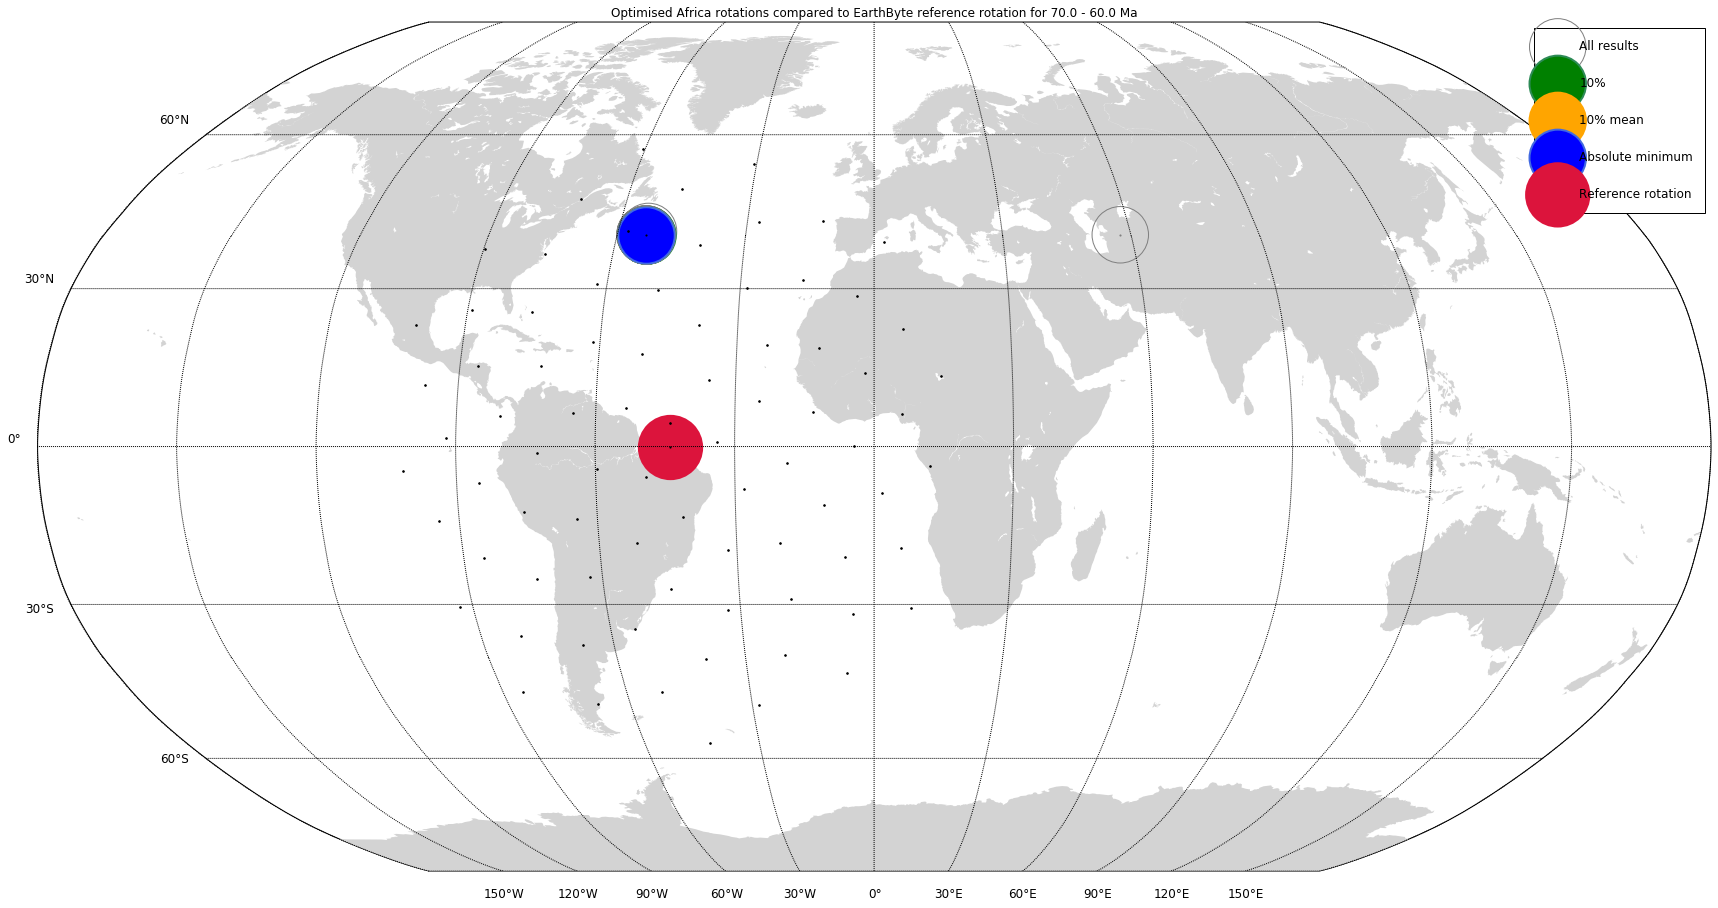

 
Reference rotation from 70.0 - 60.0 for plate ID 701.
Plot produced from 80 models. Size of circles proportional to angle magnitude.
EarthByte reference model:  /Users/MikeT/IPython/scripting/optAPM/data/Global_EarthByte_230-0Ma_GK07_AREPS_optAPM002.rot
 
Absolute minimum rotation:


Lon,Lat,Ang
-53.197545,40.278386,-15.942135


None
 
10% mean rotation:


Lon,Lat,Ang
-53.23097,40.258411,-15.917945


None
 
Starting ref rotation:
Lon: -43.9  - Lat: -0.0  - Ang: -20.0331491713
0d, 22h, 21m, 33s.


In [36]:
# Plot results

pr.sortAndPlot(output_file, ref_rotation_start_age, ref_rotation_end_age, rotation_age_of_interest_age, xopt, 
               rotation_file, ref_rot_longitude, ref_rot_latitude, ref_rot_angle, seed_lons, seed_lats, 
               ref_rotation_plate_id)


end_time = round(time.time() - start, 2)
sec = timedelta(seconds = float(end_time))
dt = datetime(1,1,1) + sec

print str(dt.day-1) + "d, " + str(dt.hour) + "h, " + str(dt.minute) + "m, " + str(dt.second) + "s."


NR = ~200-300
FZ = ~300
TM = ~300-400
HS = ~200-300